In [126]:
import pandas as pd 
import numpy as np
import seaborn as sns #热力图
import itertools 
import datetime
import matplotlib.pyplot as plt #画图
import statsmodels.api as sm 
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller #ADF检验
from statsmodels.stats.diagnostic import acorr_ljungbox #白噪声检验
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf #画图定阶
from statsmodels.tsa.arima.model import ARIMA #ARIMA模型
from statsmodels.stats.stattools import durbin_watson #DW检验
from statsmodels.graphics.api import qqplot #qq图
import warnings                                  # 勿扰模式
warnings.filterwarnings('ignore')

In [127]:
#### Part:generate raw data and save in the old_data.csv 
#### 创建一个时间列表，从20180101到20180901数据，存入 old_data.csv 
def genertate_data():
    index = pd.date_range(start='2018-1-1',end = '2018-9-1',freq='10T') # 10分钟采样一次
    index = list(index)
    data_list = []
    for i in range(len(index)): 
        data_list.append(np.random.randn())  # 数据是符合标准正态分布的样本
    dataframe = pd.DataFrame({'time':index,'values':data_list})
    dataframe.to_csv('F:\\DZQ\\0桌面\\old_data.csv',index=0)
    print('the data is existting')

In [128]:
#### Step 1 数据预处理
#### delete or revise some values in data and make data preprocessing
#### 删掉或者修改创建的数据后，进行简单数据预处理 
def data_preprocessing():
    data = pd.read_csv('F:\\DZQ\\0桌面\\old_data.csv')
    #print(data.describe()) #查看统计信息,发现最小值有-10000的异常数据
    #print((data.isnull()).sum()) #查看是否存在缺失值
    #print((data.duplicated()).sum()) #重复值
    def change_zero(x):
        if x == -10000:
            return 0
        else :
            return x
    data['values'] = data['values'].apply(lambda x: change_zero(x))
 
    #利用均值填充缺失值
    mean = data['values'].mean()
    def change_mean(x):
        if x == 0:
            return mean
        else:
            return x
    data['values'] = data['values'].apply(lambda x: change_mean(x))
    #保存处理过的数据
    data.to_csv('F:\\DZQ\\0桌面\\new_data.csv',index=0)
    print('new data is existing')

In [129]:
#### Step 2 重采样
#### Resample Data and Sampling frequency is days
#### 重采样，将采样频率换成以天为单位
def Resampling(): #重采样
    df = pd.read_csv('F:\\DZQ\\0桌面\\new_data.csv')
     #将默认索引方式转换成时间索引
    df['time'] = pd.to_datetime(df['time'])
    df.set_index("time", inplace=True)
   
    train_data = df['2018-1-1':'2018-8-1'] ## 取到20180101 至 20180801 做训练 
    test = df['2018-8-1':'2018-9-1']       ## 取到20180801 至 20180901 做预测 
    train_data = train_data.resample('D').mean()  ## 以天为时间间隔取均值,重采样
    test_data = test.resample('D').mean()
 
    return train_data,test_data

In [130]:
#### Step 3  差分转平稳
def stationarity(timeseries): #平稳性处理（timeseries 时间序列）
    ## 差分法,保存成新的列
    diff1 = timeseries.diff(1).dropna()  # 1阶差分 dropna() 删除缺失值
    diff2 = diff1.diff(1) #在一阶差分基础上再做一次一阶差分，即二阶查分
    ## 画图
    diff1.plot(color = 'red',title='diff 1',figsize=(10,4))
    diff2.plot(color = 'black',title='diff 2',figsize=(10,4))
 
    
    ## 平滑法
    rollmean = timeseries.rolling(window=4,center = False).mean() ## 滚动平均
    rollstd = timeseries.rolling(window=4,center = False).std() ## 滚动标准差
    ## 画图 
    rollmean.plot(color = 'yellow',title='Rolling Mean',figsize=(10,4))
    rollstd.plot(color = 'blue',title='Rolling Std',figsize=(10,4))
    
    return diff1,diff2,rollmean,rollstd

In [131]:
#### Step 4  平稳性检验
def ADF_test(timeseries): ## 用于检测序列是否平稳
    x = np.array(timeseries['values'])
    adftest = adfuller(x, autolag='AIC')
    #print (adftest) 
    if adftest[0] < adftest[4]["1%"] and adftest[1] < 10**(-8): 
    # 对比Adf结果和10%的时的假设检验 以及 P-value是否非常接近0(越小越好)
        print("序列平稳")
        return True 
    else:
        print("非平稳序列")
        return False
 
def random_test(timeseries) : #随机性检验（白噪声检验）
    p_value = acorr_ljungbox(timeseries, lags=[1])  # p_value 返回二维数组，第二维为P值
    if (p_value['lb_pvalue'])[1] < 0.05: 
        print("非随机性序列")
        return  True
    else:
        print("随机性序列,即白噪声序列")
        return False

In [132]:
def determinate_order_acf(timeseries): #利用ACF和PACF判断模型阶数 
    plot_acf(timeseries,lags=40) #延迟数
    plot_pacf(timeseries,lags=40)
    plt.show()
     
def detetminante_order_AIC(timeseries): #信息准则定阶：AIC、BIC、HQIC
    #AIC
    AIC = sm.tsa.arma_order_select_ic(timeseries,\
        max_ar=6,max_ma=4,ic='aic')['aic_min_order']
    #BIC
    BIC = sm.tsa.arma_order_select_ic(timeseries,max_ar=6,\
           max_ma=4,ic='bic')['bic_min_order']
    #HQIC
    HQIC = sm.tsa.arma_order_select_ic(timeseries,max_ar=6,\
                 max_ma=4,ic='hqic')['hqic_min_order']
    print('the AIC is{},\nthe BIC is{}\n the HQIC is{}'.format(AIC,BIC,HQIC))
 
def heatmap_AIC(timeseries):
    #设置遍历循环的初始条件，以热力图的形式展示，原理同AIC，BIC，HQIC定阶
    p_min = 0
    q_min = 0
    p_max = 5
    q_max = 5
    d_min = 0
    d_max = 5
    # 创建Dataframe,以BIC准则
    results_aic = pd.DataFrame(index=['AR{}'.format(i) \
                               for i in range(p_min,p_max+1)],\
            columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])
    # itertools.product 返回p,q中的元素的笛卡尔积的元组
    for p,d,q in itertools.product(range(p_min,p_max+1),\
                                   range(d_min,d_max+1),range(q_min,q_max+1)):
        if p==0 and q==0:
            results_aic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
            continue
        try:
            model = sm.tsa.ARIMA(timeseries, order=(p, d, q))
            results = model.fit()
            #返回不同pq下的model的BIC值
            results_aic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.aic
        except:
            continue
    results_aic = results_aic[results_aic.columns].astype(float)
    #print(results_bic)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax = sns.heatmap(results_aic,
                 #mask=results_aic.isnull(),
                 ax=ax,
                 annot=True, #将数字显示在热力图上
                 fmt='.2f',
                 )
    ax.set_title('AIC')
    plt.show() 

In [133]:
def ARMA_model(train_data,order): # 训练数据,测试数据,定阶
    arma_model = ARMA(train_data,order=order) #ARMA模型
    arma = arma_model.fit()#激活模型
    #print(result.summary()) #给出一份模型报告
    
    ############ in-sample ############ 样本内预测 
    in_sample_pred = arma.predict()
 
    ############ out-sample ########## 样本外预测
    #### 样本外预测需要从train_data 样本内的某一个时间节点开始
    #### 利用start和end 控制样外预测 起止时间
    out_sample_pred = arma.predict(start=len(train_data)-2,end = len(train_data)+30, \
                              dynamic=True) 
    #in_sample_pred.plot()
    #train_data.plot()
    return arma,in_sample_pred,out_sample_pred
 
def ARIMA_model(train_data,order):
    arima_model = ARIMA(train_data,order=order) #ARIMA模型
    arima = arima_model.fit()
    #print(result.summary()) #给出一份模型报告
    
    ########样本内预测#########
    in_sample_pred = arima.predict()
 
 
    ####### 样本外预测##########
    out_sample_pred = arima.predict(start=len(train_data)-2,end = len(train_data)+30, \
                              dynamic=True)
 
    return arima,in_sample_pred,out_sample_pred

In [134]:
def evaluate_model(model,train_data,predict_data):
    
    ###（1）利用QQ图检验残差是否满足正态分布
    resid = model.resid  # 求解模型残差
    plt.figure(figsize=(12,8))
    qqplot(resid,line='q',fit=True)
 
    ###（2）利用D-W检验,检验残差的自相关性
    print('D-W检验值为{}'.format(durbin_watson(resid.values)))
 
    ###（3）利用预测值和真实值的误差检测，这里用的是标准差
    #row_train_data 是从 2018-1-1开始的,经过差分后train_data发生变化
    print('标准差为{}'.format(mean_squared_error(train_data,predict_data,sample_weight=None,\
        multioutput='uniform_average'))) #标准差（均方差）
 
 
def string_toDatetime(string): # 截取时间
    return  datetime.datetime.strptime(string, "%Y-%m-%d %H:%M:%S")
 
#### 绘制图像,查看预测效果
def draw_picture(row_train_data,out_sample_pred,test_data): 
    #print(out_sample_pred)
    # 样本外预测传入 test_data,out_sample_pred
    # 由于预测都是由差分后的平稳序列得出,因此需要对差分后的数据进行还原
    # 还原后绘制同一起点的曲线
 
    #######还原 out_sample_pred #########
    #### out_sample 2018-07-31 
    #### test_data 2018-8-1
    
    ##2018-8-1 00:00 到 2018-9-1 00:00 ###
    #将差分后的序列还原,re_out_sample_pred为还原之后
    re_out_sample_pred = pd.Series(np.array(row_train_data)[-2][0],\
         index=[row_train_data.index[-2]]).append(out_sample_pred[1:]).cumsum()
   
    
    #### 横坐标 
    x = []
    for i in range(32):
        x.append(i+1)
    x = np.array(x)
    
    #### 纵坐标
    y1 = np.array(test_data)
    y2 = np.array(re_out_sample_pred[1:])
    
    #### 画图
    plt.plot(x,y1,color='blue')
    plt.plot(x,y2,color='red')
    plt.show()

In [135]:
    genertate_data() # 生成数据
    data_preprocessing() # 1：数据预处理 
    train_data,test_data = Resampling() #:2：数据重采样,返回训练数据和测试数据
    row_train_data = train_data # 保存差分前的序列,为了后面做评估

the data is existting
new data is existing


序列平稳
非随机性序列
0


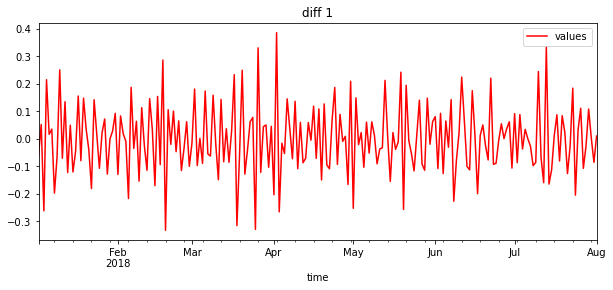

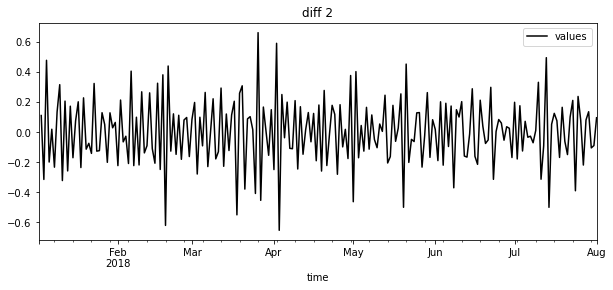

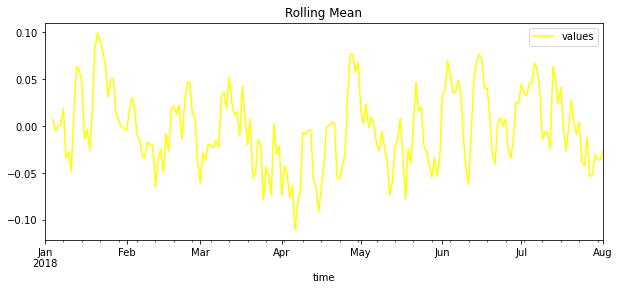

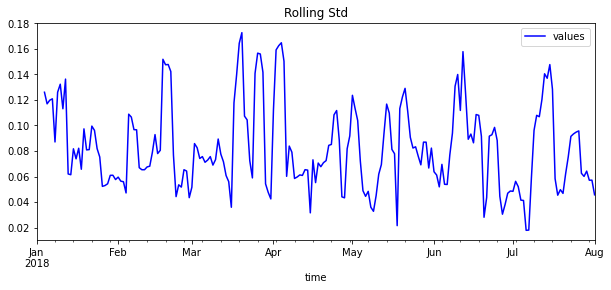

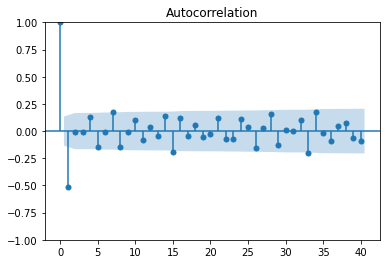

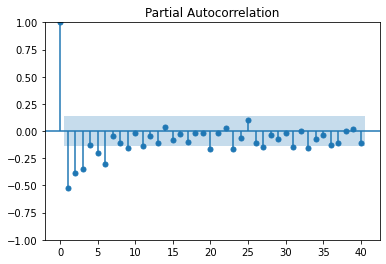

the AIC is(3, 3),
the BIC is(0, 1)
 the HQIC is(0, 1)


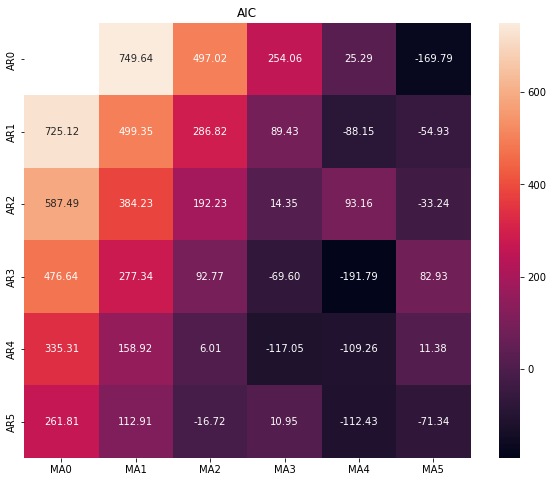

D-W检验值为2.037637254253831
标准差为0.0084314871971844


<Figure size 864x576 with 0 Axes>

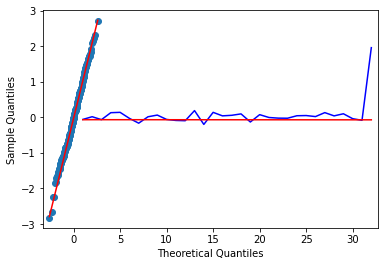

In [136]:
if __name__ == "__main__":
    Smooth_data = stationarity(train_data) # 4 差分
 
    for data in zip(Smooth_data,range(4)):# range(4) 用于判断哪种方法 满足平稳性和白噪声  
        if ADF_test(data[0])  and  random_test(data[0]) : # 平稳性和白噪声检测
            train_data = data[0]    # 先用差分，再用平滑,分别对应4个序列
            method = data[1]
            print(method)  #### 如果是差分做的,那么后面ARIMA模型中要使用这个参数
            break 
    ## 三种选择一种即可
    determinate_order_acf(train_data) # ACF定阶
    detetminante_order_AIC(train_data) # BIC 定阶
    heatmap_AIC(train_data) # 热力图 显示
    #### 模型建议和模型评价
    #### order 由差分和定阶给出
#     order = (1,1) ## ARMA p,q
    order = (0,1,4) ## ARIMA  p,d,q
    #### 调用模型
#     arma,in_sample_pred,out_sample_pred = ARMA_model(train_data,order)
    arima,in_sample_pred,out_sample_pred = ARIMA_model(train_data,order)
    
    #### 模型评价（样本内外均可,此处只用于样本内）
#     evaluate_model(arma,train_data,in_sample_pred) # 样本内预测
    evaluate_model(arima,train_data,in_sample_pred) # 样本内预测
   
    #### 画图-差异比较（样本外预测）
    draw_picture(row_train_data,out_sample_pred,test_data)